In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import cv2
import glob

import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from tifffile import imread
import segmentation_models as sm
from random import randint, shuffle

import tensorflow as tf
from keras.utils import to_categorical

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Import dataset

In [4]:
class Dataset():
    
    def __init__(
            self, 
            export_uri,
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            
    ):
        self.classes = classes


        self.images_fps = []
        self.masks_fps = []

        # Loop through all downsamples
        # for downsample in os.listdir(export_uri):
        #     for image_id in os.listdir(os.path.join(export_uri, downsample, 'images')):
        #         self.images_fps.append(os.path.join(export_uri, downsample, 'images', image_id))

        #     for mask_id in os.listdir(os.path.join(export_uri, downsample, 'masks')):
        #         self.masks_fps.append(os.path.join(export_uri, downsample, 'masks', mask_id))

        # Loop through downsample x1
        for image_id in os.listdir(os.path.join(export_uri, '1', 'images')):
            self.images_fps.append(os.path.join(export_uri, '1', 'images', image_id))

        for mask_id in os.listdir(os.path.join(export_uri, '1', 'masks')):
            self.masks_fps.append(os.path.join(export_uri, '1', 'masks', mask_id))

        to_collect = [5, 5, 5, 5, 5]
        self.images_test_fps = []
        self.masks_test_fps = []

        for image_path, mask_path in zip(self.images_fps, self.masks_fps):
            mask = np.asarray(imread(mask_path), dtype=np.uint8)

            un = np.unique(self.to_index(mask))[-1]
            if to_collect[un - 1] == 0:
                continue 

            to_collect[un - 1] -= 1
            self.images_test_fps.append(image_path)
            self.masks_test_fps.append(mask_path)

            self.images_fps.remove(image_path)
            self.masks_fps.remove(mask_path)

            if all(x == 0 for x in to_collect):
                break 

        # convert str names to class values on masks
        self.class_values = [classes.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    

    def merge(self, x):
        dim = (x.shape[-2], x.shape[-1])
        merged = np.zeros(dim)
        for i in range(len(self.classes)):
            merged = np.where(merged==0, x[i], merged)

        merged  = merged.reshape(dim[0], dim[1], 1)

        return merged


    def to_index(self, x):
        for c in range(len(self.classes)):
            x[c][x[c] == 255] = c + 1
        
        return x


    def export_split(self, a, b, ratio = 0.5, cat = False):
        
        l_size = int(len(a) * ratio)

        images = []
        for image_uri in a:
            img = np.asarray(imread(image_uri), dtype=np.uint8)
            images.append(img)
        
        images = np.asarray(images)

        masks = []
        for mask_uri in b:
            mask = np.asarray(imread(mask_uri), dtype=np.uint8)
            mask = self.to_index(mask)
            mask = self.merge(mask)
            masks.append(mask)
        
        masks = np.asarray(masks)

        print(images.shape, masks.shape)

        if cat:
            masks = to_categorical(masks, num_classes=len(self.classes) + 1)

        x_left = images[:l_size]
        y_left = masks[:l_size]

        x_right = images[l_size:]
        y_right = masks[l_size:]

        return x_left, y_left, x_right, y_right


    def __getitem__(self, i):
        
        # read data
        image = np.asarray(imread(self.images_fps[i]), dtype=np.uint8)
        mask = np.asarray(imread(self.masks_fps[i]), dtype=np.uint8)

        mask = self.to_index(mask)
        mask = self.merge(mask)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [5]:
# FOCUS ON 256px*256px images
export_uri = r'D:\NSC2024\annotated\jj\export\256'

dataset = Dataset(
    export_uri=export_uri,
    classes = ['lepidic', 'acinar', 'micropapillary', 'papillary', 'solid'],
)

print(len(dataset))

528


[0. 1.]
(256, 256, 1)


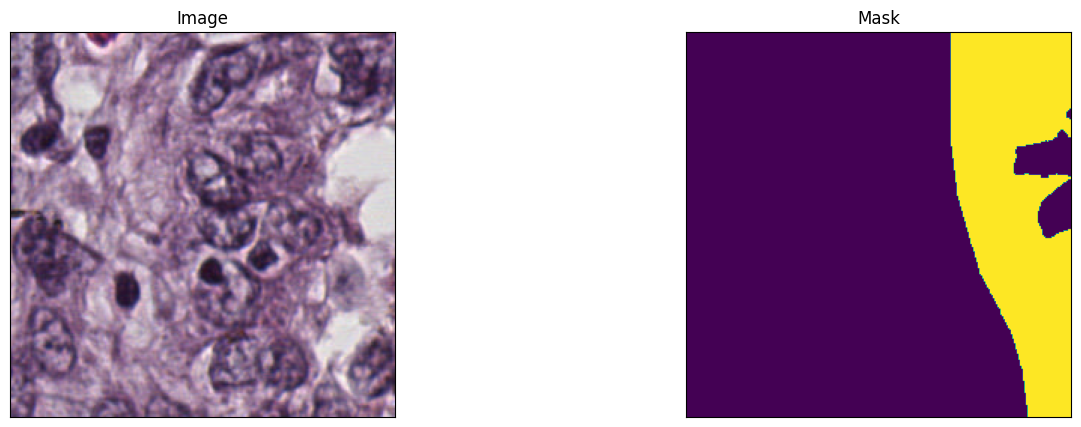

In [6]:
r = randint(0, len(dataset) - 1)
image, masks = dataset[r]
print(np.unique(masks))
print(masks.shape)
visualize(
    image=image,
    mask=masks
)


In [26]:
import keras

BACKBONE = 'resnet101'
activation='softmax'
LR = 0.0001
opt = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0, 0.20, 0.20, 0.20, 0.20, 0.20])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

preprocess_input = sm.get_preprocessing(BACKBONE)

In [27]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='iou_score',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    save_freq='epoch',
    initial_value_threshold=None
)

Name = "Unet-" + BACKBONE
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format(Name))

In [28]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=len(dataset.classes)+1, activation=activation)

# compile keras model with defined optimizer, loss and metrics
model.compile(opt, total_loss, metrics=metrics)

# model.summary()

In [29]:
SET_SIZE = 100
cnt = 1

goal = len(dataset)
# goal = 100

for i in range(0, goal, SET_SIZE):
    x_train, y_train, x_val, y_val = dataset.export_split(
                                                        dataset.images_fps[i:i+SET_SIZE], 
                                                        dataset.masks_fps[i:i+SET_SIZE], 
                                                        ratio=0.5,
                                                        cat=True)
    
    r = randint(0, len(x_train)-1)
    print("EXPORTED SHAPE: ", x_train.shape, y_train.shape)


    pre_x_train = preprocess_input(x_train)
    pre_x_val = preprocess_input(x_val)

    history = model.fit(pre_x_train, 
            y_train,
            validation_data=(pre_x_val, y_val),
            batch_size=16, 
            verbose=1,
            epochs=20,
            callbacks=[checkpoint, tensorboard]
            )

    model.save(f'latest_round_{cnt}.keras')
    cnt += 1
    

(100, 256, 256, 3) (100, 256, 256, 1)
EXPORTED SHAPE:  (50, 256, 256, 3) (50, 256, 256, 6)
Epoch 1/20


KeyboardInterrupt: 

In [108]:
from keras.models import load_model

model = load_model('./best_model.keras', compile=False)

In [109]:
x_test, y_test, x_tmp, y_tmp = dataset.export_split(dataset.images_test_fps, dataset.masks_test_fps, 1, cat=False)

(20, 256, 256, 3) (20, 256, 256, 1)


In [110]:
pre_x_test = preprocess_input(x_test)
y_pred = model.predict(pre_x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [111]:
print(y_pred_argmax.shape)
np.unique(y_pred_argmax)

(20, 256, 256)


array([0, 1, 2, 3, 4, 5], dtype=int64)

In [112]:
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=len(dataset.classes)+1)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.21220832


In [113]:
def gray_to_rgb(x):
    x_reshaped = np.concatenate([x] * 3, axis=-1)
    color_map = {
            1: [255, 0, 0],   # Red for lepidic
            2: [0, 255, 0],   # Green for acinar
            3: [0, 0, 255],    # Blue for micropapillary
            4: [255, 255, 0],  # Yellow for papillary
            5: [255, 0, 255],   # violet for solid
        }
    
    rgb = np.zeros_like(x_reshaped, dtype=np.uint8)
    for label, color in color_map.items():
            rgb[x_reshaped[..., 0] == label] = color 
    return rgb


In [114]:
# Convert to colors according to classes
y_test_show_rgb = gray_to_rgb(y_test)

y_pred_argmax = np.expand_dims(y_pred_argmax, axis=-1)
y_pred_argmax_show_rgb = gray_to_rgb(y_pred_argmax)


(20, 256, 256, 1)
[0 1 2 3 5]
Index:  18


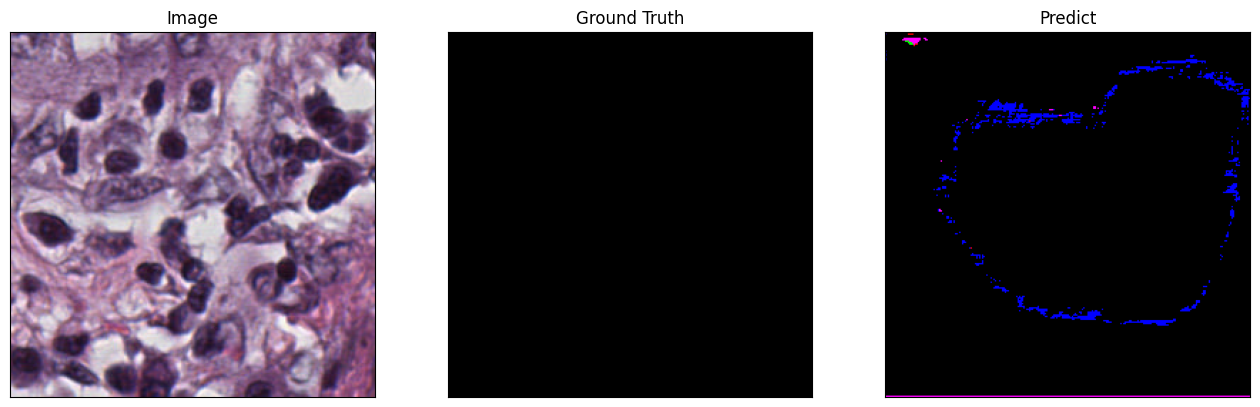

In [129]:
idx = randint(0, len(x_test)-1)
# idx = 19
print(y_test.shape)
print(np.unique(y_pred_argmax[idx]))
print("Index: ", idx)

visualize(
    image=x_test[idx],
    ground_truth=y_test_show_rgb[idx],
    predict=y_pred_argmax_show_rgb[idx]
)
